In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
from numba import jit, njit
from time import perf_counter as tpc
import scipy as sp
import scipy.special

import ttgames as tg
import tntorch as tn
import torch

from matplotlib import pyplot as plt
import seaborn
import itertools

from construct_TT import tens, add_func, mult_and_mean

## Cooperative games, common funcs

In [2]:
from math import fsum

def pi_usual(n, N):
    #return math.factorial(S)*(N - S - 1)/math.factorial(N)
    d = (N*sp.special.binom(N-1, n))
    if d == 0:
        print(f"bad in pi : {n=}, {N=}")
    return 1./d



@jit
def brute_force(N, pi_store, nu, k):

    val = 0
    c = 0
    #val = np.empty(2**(N-1))
    
    for i in range(2**(N-1)):
        S = np.zeros(N-1, dtype=np.int32)
        i_iter = i
        for j in range(N-1):
            #S[j] = 0 + ((i & pow2[j]) > 0)
            S[j] = i_iter % 2
            i_iter //= 2
            if i_iter == 0:
                break
            
        
        S_join_k = np.zeros(N, dtype=np.int32)
        S_join_k[:k] = S[:k]
        S_join_k[k+1:] = S[k:]
        nu_wo_k = nu(S_join_k)

        S_join_k[k] = 1
        nu_k = nu(S_join_k)
        
        #val += pi_store[S.sum()]*(nu_k - nu_wo_k)
        #Kahan summation 
        y = pi_store[S.sum()]*(nu_k - nu_wo_k) - c
        t = val + y
        c = (t - val) - y
        val = t        
        
    
    return val


@jit
def nu_shoes(S):
    L = (len(S))//2
    return min(S[:L].sum(), S[L:].sum())



def brute_force_expr(range_N, nu_in, pi=pi_usual):
    times_bf = dict()
    res = dict()
    for N in range_N:
        print(N)
        t = tpc()
        pi_store = np.zeros(N)
        for i in range(N):
            pi_store[i] = pi(i, N)

        cur_res = res[N] = []
        if isinstance(nu_in, dict):
            nu = nu_in[N]
            print(f"nu with {N}")
        else:
            nu = nu_in
            
        for k in range(N):
            rr = brute_force(N, pi_store, nu, k)
            cur_res.append(rr)


        tm = tpc() - t
        times_bf[N] = tm
        
    return res, times_bf
    
def tn_cross_expr(game, eps):
    t0 = tpc()
    tens = tn.cross(function=game.function, domain=game.domain(), function_arg='matrix', eps=eps)
    res = tg.semivalues.semivalues(tens, ps='shapley')
    times = tpc() - t0
    return res, times


def plot_errs(res_bf, ress, names, 
             x_label='Number of players, $N=2L+1$',
             title='Shoes game',
             fn='coop_games_choes_errs.pdf'): 
    plt.figure(figsize=(7, 7))
    plt.plot([15], [-13])
    for r, n in zip(ress, names):
        X = sorted(list(r))
        X = [i for i in X if i in r and i in res_bf]
        Y = []
        for i in X:
            bf_i = np.asarray(res_bf[i])
            err_i = np.asarray(r[i])
            Y.append(np.linalg.norm(bf_i - err_i)/np.linalg.norm(bf_i))


        plt.plot(X, Y, label=n)
    plt.yscale('log');
    plt.title(title)
    plt.xlabel(x_label)
    #plt.ylabel('Rel. error');
    plt.legend();
    plt.savefig(fn);
    


def plot_times(times, names, 
             x_label='Number of players, $N=2L+1$',
             title='Shoes game',
             fn='coop_games_choes_times.pdf'): 
    plt.figure(figsize=(7, 7))
    for r, n in zip(times, names):
        X = sorted(list(r))
        Y = [r[i] for i in X]


        plt.plot(X, Y, label=n)
    plt.yscale('log');
    plt.title(title)
    plt.xlabel(x_label)
    #plt.ylabel('Time (s)');
    plt.legend();
    plt.savefig(fn);

## Shoes

### Brute Force

In [3]:
res_shoes, times_shoes = brute_force_expr([3] + list(range(15, 24, 2)), nu_shoes)
print(times_shoes)
print(res_shoes[15])

3
15
17
19
21
23
{3: 0.9374135450000001, 15: 0.06347747799999937, 17: 0.2831208690000002, 19: 1.2672831430000002, 21: 5.610511923000001, 23: 24.599291283}
[0.6104340104340105, 0.6104340104340105, 0.6104340104340105, 0.6104340104340105, 0.6104340104340105, 0.6104340104340105, 0.6104340104340105, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087, 0.34087024087024087]


### tt-cross

In [4]:
max_N = 35
res_cross_shoes = dict()
times_cross_shoes = dict()
for N in range(15, max_N, 2):
    game = tg.games.Shoes(N=N)
    game.L = (N-1)//2 # due to another def. of L in the package tg
    r, t = tn_cross_expr(game, 1e-2)
    res_cross_shoes[N] = r
    times_cross_shoes[N] = t


cross device is None
Cross-approximation over a 15D domain containing 32768 grid points:
iter: 0  | eps: 4.665e-01 | time:   0.0426 | largest rank:   1
iter: 1  | eps: 1.085e-01 | time:   0.1264 | largest rank:   4
iter: 2  

/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/tntorch/cross.py:277: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  Q, R = torch.qr(V)
/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/tntorch/cross.py:282: UserWarning: torch.lstsq is deprecated in favor of torch.linalg.lstsq and will be removed in a future PyTorch release.
torch.linalg.lstsq has reversed arguments and does not return the QR decomposition in the returned tuple (although it returns other information about the problem).
To get the qr decomposition consider using torch.linalg.qr.
The returned solution in torch.lstsq stored the residuals of the solution in the last m - n columns of

| eps: 4.940e-02 | time:   0.2108 | largest rank:   7
iter: 3  | eps: 2.541e-02 | time:   0.2995 | largest rank:  10
iter: 4  | eps: 7.371e-07 | time:   0.3888 | largest rank:  13 <- converged: eps < 0.01
Did 12570 function evaluations, which took 0.01107s (1.135e+06 evals/s)

cross device is None
Cross-approximation over a 17D domain containing 131072 grid points:
iter: 0  | eps: 6.273e-01 | time:   0.0469 | largest rank:   1
iter: 1  | eps: 1.263e-01 | time:   0.1567 | largest rank:   4
iter: 2  | eps: 5.499e-02 | time:   0.2675 | largest rank:   7
iter: 3  | eps: 8.873e-03 | time:   0.3815 | largest rank:  10 <- converged: eps < 0.01
Did 8002 function evaluations, which took 0.01035s (7.732e+05 evals/s)

cross device is None
Cross-approximation over a 19D domain containing 524288 grid points:
iter: 0  | eps: 6.658e-01 | time:   0.0559 | largest rank:   1
iter: 1  | eps: 1.583e-01 | time:   0.2058 | largest rank:   4
iter: 2  | eps: 4.271e-02 | time:   0.3495 | largest rank:   7
iter

### Constructive

In [5]:
def f_n(x):
    s1 = sum(x[:L])
    s2 = sum(x[L:])
    return min(s1, s2)


def f_last_gen(d):
    def f_last(x):
        if x + d > 0:
            return x + d
    return f_last

def f_l(x):
    return x + 1

@njit
def last_univ(x, y, d):
    res = min(x, y + d)
    return res


@njit
def last_univ_abs_and_main(x, y, d, N, include_k, pi_store):
    S = x + y + d
    if include_k:
        S -= 1
    if S < 0 or S >= N:
        return None
    res = min(x, y + d)*pi_store[S]

    return res

In [6]:
def tens_for_k(N=19, include_k=False, k=0):
    L = (N-1)//2
    lf_funcs = [[add_func(0), f_l]]*L
    lf_funcs_p = [[add_func(0), f_l]]*L
    
    if 0 <= k < L:
        lf_funcs[k] = [f_l] if include_k else [add_func(0)]
    if k > L:
        lf_funcs_p[k - L - 1] = [f_l] if include_k else [add_func(0)]

    pi_store = np.array([pi_usual(i, N) for i in range(N)])
    lf_mid = [lambda x, y : last_univ_abs_and_main(x, y, 0, 2*L+1, include_k, pi_store),\
              lambda x, y : last_univ_abs_and_main(x, y, 1, 2*L+1, include_k, pi_store)]
    
    if k == L:
        lf_mid = [lf_mid[1]] if include_k else [lf_mid[0]]


    funcs = [lf_funcs, lf_funcs_p, lf_mid]
    t = tpc()
    t_mul = tens(funcs)

    return t_mul

times = dict()
for N in [101]:
    t = tpc()
    for k in range(N):
        t_mul = tens_for_k(N=N, include_k=False, k=k)
        t_mul_incl = tens_for_k(N=N, include_k=True, k=k)
        #print(t_mul_incl.simple_mean() - t_mul.simple_mean(), end='')
        print(t_mul_incl.simple_mean_func() - t_mul.simple_mean_func(), end='')

    tm = tpc() - t
    print(f"\nTime: {tm:.5f} sec")
    times[N] = tm

0.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.5534445700984740.43779944107992820.437799441079924630.437799441079924630.437799441079924630.437799441079924630.437799441079924630.437799441079924630.4377994410799246

In [7]:
def sunstract_tens(t, t_incl, k):
        
        save_core = t.cores[k]
        save_core_incl = t_incl.cores[k]
        t._cores[k] = save_core[:, 0:1, :]
        t_incl._cores[k] = save_core_incl[:, 1:2, :]
        
        res = t_incl.simple_mean() - t.simple_mean()
        
        t._cores[k] = save_core
        t_incl._cores[k] = save_core_incl
        
        return res

times_constr = dict()
res_constr = dict()
for N in range(15, 40, 2):
    t = tpc()
    t_mul = tens_for_k(N=N, include_k=False, k=-1)
    t_mul_incl = tens_for_k(N=N, include_k=True, k=-1)
    res = res_constr[N] = []
    for k in range(N):
        rr = sunstract_tens(t_mul, t_mul_incl, k)
        res.append(rr)


    tm = tpc() - t
    #print(f"Time: {tm:.5f} sec")
    times_constr[N] = tm

### plot

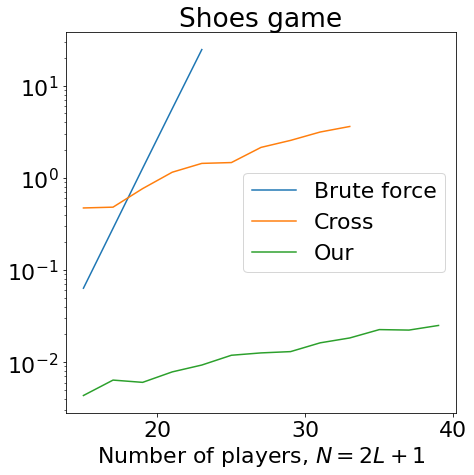

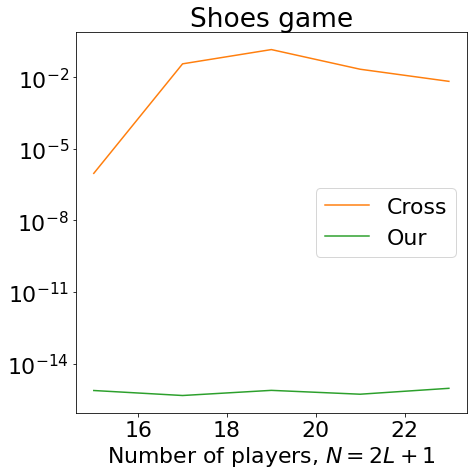

In [8]:
plt.rcParams.update({'font.size': 22})
times_sh_ = {i: el for i, el in times_shoes.items() if i > 5}
plot_times([times_sh_, times_cross_shoes, times_constr], 
           ['Brute force', r'Cross', 'Our'],
            title='Shoes game',
             fn='times_for_coop_games_shoes_times.pdf')


plot_errs(res_shoes, [res_cross_shoes, res_constr], 
           [r'Cross', 'Our'], fn='times_for_coop_games_shoes_res.pdf')

# Weighted majority game

### brute force

In [9]:
min_N, max_N = 15, 30
data_maj = dict()
for N in list(range(1, 5)) + list(range(min_N, max_N)):
    game = tg.games.WeightedMajority(seed=N, N=N)
    M = game.threshold
    w = game.seats
    data_maj[N] = {'M': M, 'w': np.array(w)}



def brute_force_expr(range_N, pi=pi_usual, data_maj=data_maj):
    times_bf = dict()
    res = dict()
    for N in range_N:
        print(N)
        t = tpc()
        pi_store = np.zeros(N)
        for i in range(N):
            pi_store[i] = pi(i, N)

        cur_res = res[N] = []

        M = data_maj[N]['M']
        w = np.array(data_maj[N]['w'])
        
        @njit
        def nu(S):
            return 0 + (w[S==1].sum() >= M)

        for k in range(N):
            rr = brute_force(N, pi_store, nu, k)
            cur_res.append(rr)
            #print(rr, end='')

        tm = tpc() - t
        times_bf[N] = tm
        
    return res, times_bf


res_maj, times_maj = brute_force_expr(list(range(1, 5)) + list(range(min_N, 24)))
print(times_maj)
print(res_maj[15])

1
2
3
4
15
16
17
18
19
20
21
22
23
{1: 0.4630792179999972, 2: 0.4880265119999976, 3: 0.37896970899999616, 4: 0.35176253399999524, 15: 0.6769419419999991, 16: 0.7626644189999965, 17: 1.2009126720000012, 18: 2.042570289000004, 19: 4.017009166999998, 20: 7.883494884000001, 21: 16.16893243300001, 22: 33.58338533199999, 23: 70.391628966}
[0.12153402153402153, 0.12153402153402153, 0.12153402153402153, 0.12153402153402153, 0.09378399378399378, 0.09378399378399378, 0.05690975690975691, 0.05690975690975691, 0.0445998445998446, 0.0445998445998446, 0.0445998445998446, 0.032722832722832725, 0.02342102342102342, 0.011266511266511266, 0.011266511266511266]


### tt-cross

In [10]:
res_cross_maj = dict()
times_cross_maj = dict()
for N in range(min_N, max_N, 2):
    game = tg.games.WeightedMajority(seed=N, N=N)
    r, t = tn_cross_expr(game, 1e-2)
    res_cross_maj[N] = r
    times_cross_maj[N] = t
    


cross device is None
Cross-approximation over a 15D domain containing 32768 grid points:
iter: 0  | eps: 9.959e-01 | time:   0.0355 | largest rank:   1
iter: 1  | eps: 5.237e-01 | time:   0.1184 | largest rank:   4
iter: 2  | eps: 3.328e-01 | time:   0.2063 | largest rank:   7
iter: 3  | eps: 2.528e-01 | time:   0.2908 | largest rank:  10
iter: 4  | eps: 1.581e-01 | time:   0.3763 | largest rank:  13
iter: 5  | eps: 1.610e-01 | time:   0.4616 | largest rank:  16
iter: 6  | eps: 6.422e-02 | time:   0.5545 | largest rank:  19
iter: 7  | eps: 6.422e-02 | time:   0.6471 | largest rank:  22
iter: 8  | eps: 6.422e-02 | time:   0.7438 | largest rank:  25
iter: 9  | eps: 6.422e-02 | time:   0.8423 | largest rank:  28
iter: 10 | eps: 4.541e-02 | time:   0.9368 | largest rank:  31
iter: 11 | eps: 4.541e-02 | time:   1.0320 | largest rank:  34
iter: 12 | eps: 1.100e-06 | time:   1.1470 | largest rank:  37 <- converged: eps < 0.01
Did 167554 function evaluations, which took 0.04469s (3.75e+06 eval

iter: 7  | eps: 2.800e-01 | time:   2.5111 | largest rank:  22
iter: 8  | eps: 2.298e-01 | time:   2.8683 | largest rank:  25
iter: 9  | eps: 2.111e-01 | time:   3.2387 | largest rank:  28
iter: 10 | eps: 1.982e-01 | time:   3.5984 | largest rank:  31
iter: 11 | eps: 1.960e-01 | time:   3.9730 | largest rank:  34
iter: 12 | eps: 1.599e-01 | time:   4.3569 | largest rank:  37
iter: 13 | eps: 1.202e-01 | time:   4.7407 | largest rank:  40
iter: 14 | eps: 1.283e-01 | time:   5.1396 | largest rank:  43
iter: 15 | eps: 1.064e-01 | time:   5.5392 | largest rank:  46
iter: 16 | eps: 7.899e-02 | time:   5.9563 | largest rank:  49
iter: 17 | eps: 7.496e-02 | time:   6.3913 | largest rank:  52
iter: 18 | eps: 6.469e-02 | time:   6.8268 | largest rank:  55
iter: 19 | eps: 7.762e-02 | time:   7.2846 | largest rank:  58
iter: 20 | eps: 8.071e-02 | time:   7.7430 | largest rank:  61
iter: 21 | eps: 6.337e-02 | time:   8.2165 | largest rank:  64
iter: 22 | eps: 6.369e-02 | time:   8.7453 | largest ra

| eps: 6.337e-02 | time:   9.8417 | largest rank:  73 <- max_iter was reached: 25
Did 3071242 function evaluations, which took 0.4832s (6.357e+06 evals/s)

cross device is None
Cross-approximation over a 29D domain containing 5.36871e+08 grid points:
iter: 0  | eps: 1.000e+00 | time:   0.1087 | largest rank:   1
iter: 1  | eps: 8.991e-01 | time:   0.5097 | largest rank:   4
iter: 2  | eps: 7.137e-01 | time:   0.9328 | largest rank:   7
iter: 3  | eps: 5.581e-01 | time:   1.3383 | largest rank:  10
iter: 4  | eps: 4.324e-01 | time:   1.7448 | largest rank:  13
iter: 5  | eps: 3.972e-01 | time:   2.1673 | largest rank:  16
iter: 6  | eps: 3.079e-01 | time:   2.5881 | largest rank:  19
iter: 7  | eps: 2.891e-01 | time:   3.0113 | largest rank:  22
iter: 8  | eps: 2.725e-01 | time:   3.4386 | largest rank:  25
iter: 9  | eps: 2.540e-01 | time:   3.8835 | largest rank:  28
iter: 10 | eps: 2.343e-01 | time:   4.3156 | largest rank:  31
iter: 11 | eps: 2.057e-01 | time:   4.7495 | largest ran

| eps: 9.996e-02 | time:  11.7206 | largest rank:  73 <- max_iter was reached: 25
Did 3438642 function evaluations, which took 0.5708s (6.024e+06 evals/s)



### Constructive

In [11]:
big_num = 2**15


res = dict()
def gen_fst_func(M, i, a, k):
    if i < k:
        add = a[i]
    else:
        add = a[i + 1]
        
    #@njit
    def f(x):
        num, x = divmod(x, big_num)
        y = x + add
        if y <= M:
            return y + big_num*(num + 1)
        
    
    return f

def f_mid(x, add, M, a_k, ps, is_in):
    num, x = divmod(x, big_num)
    if is_in > 0:
        num += 1
    
    if x + add + a_k >= M > x + add:
            res = ps[num]
            return res
      
    
times_constr_maj = dict()
res_constr_maj = dict()

for N in range(min_N, 30):
   
    a = data_maj[N]['w']
    M = data_maj[N]['M']

    res_constr_maj[N] = []
    t0 = tpc()
    ps = np.array([pi_usual(i, N) for i in range(N)])
    for k in range(N):
        lf_funcs =  [[add_func(0), gen_fst_func(M, i, a, k)] for i in range(N-2)]
        if k == N-1:
            lf_funcs_mid = [lambda x: f_mid(x, 0, M, a[k], ps, False), lambda x: f_mid(x, a[-2], M, a[k], ps, True)]
        else:
            lf_funcs_mid = [lambda x: f_mid(x, 0, M, a[k], ps, False), lambda x: f_mid(x, a[-1], M, a[k], ps, True)]

        lf_funcs.append(lf_funcs_mid)

        t_mul = tens(lf_funcs)

        res_tens = t_mul.simple_mean_func()
        res_constr_maj[N].append(res_tens)

    tm = tpc() - t0
    times_constr_maj[N] = tm
    #print(f"time: {tm} {N=}")

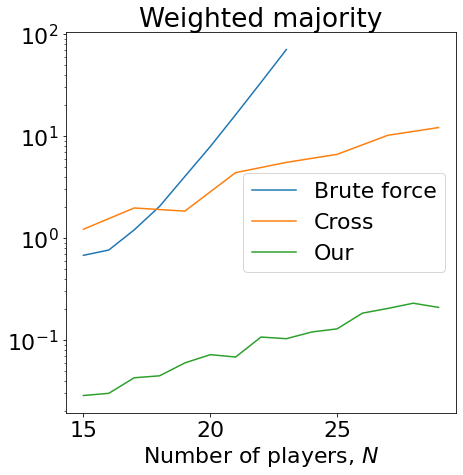

In [12]:
times_maj_ = {i: el for i, el in times_maj.items() if i > 5}
plot_times([times_maj_, times_cross_maj, times_constr_maj], 
           ['Brute force', r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Weighted majority',
             fn='times_for_coop_games_maj_times.pdf')

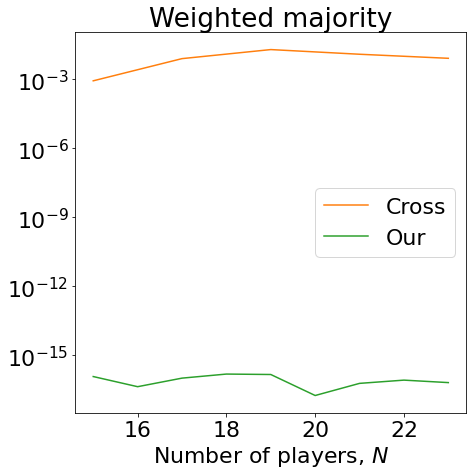

In [13]:
plot_errs(res_maj, [res_cross_maj, res_constr_maj], 
           [r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Weighted majority',
             fn='times_for_coop_games_maj_res.pdf')

#  Bankruptcy

In [14]:
min_N, max_N = 15, 30
data_bank = dict()
for N in list(range(min_N, max_N)):
    game = tg.games.Bankruptcy(seed=N, N=N)
    c = np.array(sorted(list([int(i) for i in game.c]))[::-1])
    E = c.sum()//2
    data_bank[N] = {'E': E, 'c': c}
    
    

/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/ttgames/games.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.E = torch.sum(self.c) // 2


### Brute force

In [15]:
def brute_force_expr(range_N, pi=pi_usual, data=data_bank):
    times_bf = dict()
    res = dict()
    for N in range_N:
        print(N)
        t = tpc()
        pi_store = np.zeros(N)
        for i in range(N):
            pi_store[i] = pi(i, N)

        cur_res = res[N] = []

        E = data[N]['E']
        c = data[N]['c']
        
        @njit
        def nu(S):
            val = E
            for s, c_el in zip(S, c):
                if s==0:
                    val -= c_el
                    if val <= 0:
                        return 0
                    
            return val

        for k in range(N):
            rr = brute_force(N, pi_store, nu, k)
            cur_res.append(rr)


        tm = tpc() - t
        times_bf[N] = tm
        
    return res, times_bf


res_bank, times_bank = brute_force_expr(list(range(min_N, 24)))
print(times_bank)
print(res_bank[15])

15
16
17
18
19
20
21
22
23
{15: 0.38308262300000706, 16: 0.4479776539999989, 17: 0.7794912790000126, 18: 1.126279390999997, 19: 1.9392123910000123, 20: 3.6642209340000136, 21: 7.634414456000002, 22: 16.173645436000015, 23: 36.062309073999984}
[23.918595293595295, 20.43243145743146, 16.44727217227217, 14.952572427572427, 13.955999555999556, 12.460969585969586, 11.962551337551337, 10.467612942612943, 9.969222444222444, 5.981873681873682, 4.985003885003885, 4.985003885003885, 2.4926684426684425, 1.9941114441114443, 1.9941114441114443]


### Cross

In [16]:
res_cross_bank = dict()
times_cross_bank = dict()
for N in range(min_N, max_N):
    game = tg.games.Bankruptcy(seed=N, N=N)
    game.E = data_bank[N]['E']
    game.c = torch.Tensor(data_bank[N]['c'])
    r, t = tn_cross_expr(game, 1e-2)
    res_cross_bank[N] = r
    times_cross_bank[N] = t


cross device is None
Cross-approximation over a 15D domain containing 32768 grid points:
iter: 0  

/Users/gleb/opt/anaconda3/lib/python3.9/site-packages/ttgames/games.py:101: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.E = torch.sum(self.c) // 2


| eps: 1.000e+00 | time:   0.1116 | largest rank:   1
iter: 1  | eps: 1.606e-01 | time:   0.2873 | largest rank:   4
iter: 2  | eps: 5.976e-02 | time:   0.4568 | largest rank:   7
iter: 3  | eps: 3.817e-02 | time:   0.5710 | largest rank:  10
iter: 4  | eps: 2.640e-02 | time:   0.6573 | largest rank:  13
iter: 5  | eps: 1.683e-02 | time:   0.7429 | largest rank:  16
iter: 6  | eps: 1.302e-02 | time:   0.8565 | largest rank:  19
iter: 7  | eps: 9.307e-03 | time:   1.0209 | largest rank:  22 <- converged: eps < 0.01
Did 45954 function evaluations, which took 0.06026s (7.627e+05 evals/s)

cross device is None
Cross-approximation over a 16D domain containing 65536 grid points:
iter: 0  | eps: 1.000e+00 | time:   0.0457 | largest rank:   1
iter: 1  | eps: 2.781e-01 | time:   0.1393 | largest rank:   4
iter: 2  | eps: 1.381e-01 | time:   0.2349 | largest rank:   7
iter: 3  | eps: 4.763e-02 | time:   0.3312 | largest rank:  10
iter: 4  | eps: 1.600e-02 | time:   0.4275 | largest rank:  13
ite

iter: 8  | eps: 1.234e-02 | time:   2.4492 | largest rank:  25
iter: 9  | eps: 9.999e-03 | time:   2.7526 | largest rank:  28 <- converged: eps < 0.01
Did 197430 function evaluations, which took 0.07649s (2.581e+06 evals/s)

cross device is None
Cross-approximation over a 26D domain containing 6.71089e+07 grid points:
iter: 0  | eps: 1.924e+00 | time:   0.0896 | largest rank:   1
iter: 1  | eps: 3.435e-01 | time:   0.3933 | largest rank:   4
iter: 2  | eps: 1.847e-01 | time:   0.7046 | largest rank:   7
iter: 3  | eps: 1.197e-01 | time:   1.0153 | largest rank:  10
iter: 4  | eps: 1.088e-01 | time:   1.3328 | largest rank:  13
iter: 5  | eps: 9.973e-02 | time:   1.6511 | largest rank:  16
iter: 6  | eps: 4.712e-02 | time:   1.9815 | largest rank:  19
iter: 7  | eps: 3.090e-02 | time:   2.3036 | largest rank:  22
iter: 8  | eps: 2.805e-02 | time:   2.8013 | largest rank:  25
iter: 9  | eps: 2.376e-02 | time:   3.1895 | largest rank:  28
iter: 10 | eps: 1.829e-02 | time:   3.5378 | large

### Constructive

In [17]:
big_num = 2**14

#############

def gen_fst_func(i, a, k, select=False):
    if select:
        add = 0
        add_num = 1
    else:
        if (0 <= i < k):
            add = a[i]
        else:
            add = a[i+1]
            
            
        add_num = 0
 

    def f(x):
        val, num = x
        #val = x % big_num
        if val - add > 0:
            return val - add, num + add_num
    
    return f

def gen_mid_func(a, k, select=False):
    if select:
        add = 0
    else:
        if k == len(a) - 1:
            add = a[-2]
        else:
            add = a[-1]
          
        
    a_k = a[k]
    #@njit
    def f(x):
        val, num = x
        #val = x % big_num
        val -= add
        if val > 0:
            #num = x // big_num
            return (val - max(0, val - a_k))*ps[num + select]
    
    
    return f
    


times_constr_bank = dict()
res_constr_bank = dict()

for N in range(min_N, max_N):
#for N in [23]:
    #print(f"{N=}")
    
    res_cur = res_constr_bank[N] = []
    
    a = data_bank[N]['c']
    E = data_bank[N]['E']

    t0 = tpc()
    ps = np.array([1./(N*sp.special.binom(N-1, n)) for n in range(N)])

    for k in range(N):
        #print(k)

        funcs_l =  [[gen_fst_func(i, a, k), gen_fst_func(i, a, k, True)] for i in range(N-2)]
        funcs_m =  [gen_mid_func(a, k), gen_mid_func(a, k, select=True)]
        funcs_l.append(funcs_m)
                     
        t_mul = tens(funcs_l, v_in=(E, 0))
        res_tens = t_mul.simple_mean_func()
        res_cur.append(res_tens)
        #print(f"res: {res_tens}")
    tm = tpc() - t0
    #print(f"Time: {tm:.3f} sec ({N=})")
    times_constr_bank[N] = tm


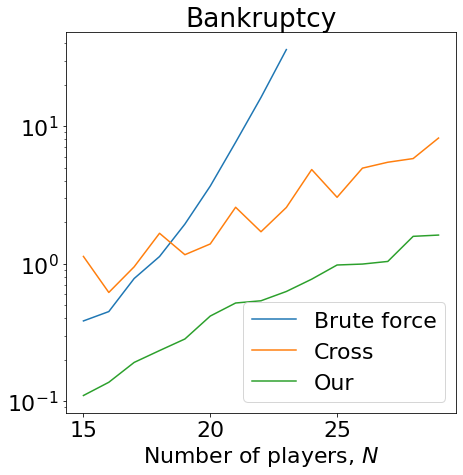

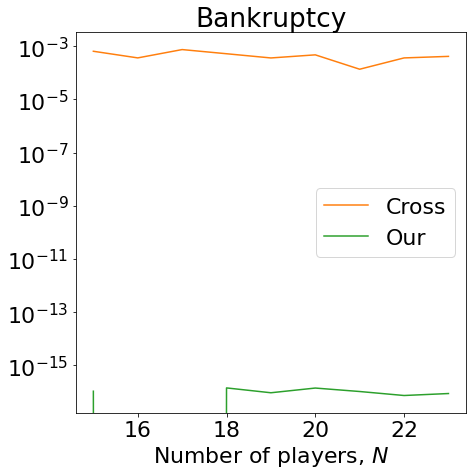

In [18]:
times_cur = {i: el for i, el in times_bank.items() if i > 5}
plot_times([times_cur, times_cross_bank, times_constr_bank], 
           ['Brute force', r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Bankruptcy',
             fn='times_for_coop_games_bank_times.pdf')


plot_errs(res_bank, [res_cross_bank, res_constr_bank], 
           [r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Bankruptcy',
             fn='times_for_coop_games_bank_res.pdf')

# Airport

### Bruteforce

In [19]:
min_N, max_N = 15, 30
data_air = dict()
for N in list(range(min_N, max_N)):
    game = tg.games.Airport(seed=N, N=N)
    a = np.array(sorted(list([i for i in game.ak]))[::-1])
    data_air[N] = {'a': a}
    
data_air[min_N]

{'a': array([0.9454356 , 0.916984  , 0.79735637, 0.6800588 , 0.56461495,
        0.5538423 , 0.50831395, 0.5026364 , 0.41249847, 0.387977  ,
        0.38687927, 0.31524175, 0.29732943, 0.2765954 , 0.22056264],
       dtype=float32)}

In [20]:
def brute_force_expr(range_N, pi=pi_usual, data=data_air):
    times_bf = dict()
    res = dict()
    for N in range_N:
        print(N)
        t = tpc()
        pi_store = np.zeros(N)
        for i in range(N):
            pi_store[i] = pi(i, N)

        cur_res = res[N] = []

        a = data[N]['a']
        
        @njit
        def nu(S):
            for s, c_el in zip(S, a):
                if s==1:
                    return c_el
                    
            return 0.0

        for k in range(N):
            rr = brute_force(N, pi_store, nu, k)
            cur_res.append(rr)
            #print(rr, end='')

        tm = tpc() - t
        times_bf[N] = tm
        
    return res, times_bf


res_air, times_air = brute_force_expr(list(range(min_N, 24)))
print(times_air)
print(res_air[15])

15
16
17
18
19
20
21
22
23
{15: 0.36639429999996764, 16: 0.39446367800002236, 17: 0.676442642999973, 18: 0.9011384480000402, 19: 1.684502760999976, 20: 3.267475052000009, 21: 5.9980330650000155, 22: 12.11130680499997, 23: 25.423433037999985}
[0.20918746807904312, 0.1807359061512477, 0.12092207887501785, 0.08182288228205113, 0.05296192585161595, 0.050807396756919906, 0.04321933804682164, 0.04240825507061663, 0.031141017705370814, 0.02841640991982801, 0.028306636045545168, 0.021794135022512724, 0.02030144100224142, 0.018706516992478144, 0.01470417579015096]


### tt-cross

In [21]:
res_cross_air = dict()
times_cross_air = dict()
for N in range(min_N, max_N):
    game = tg.games.Airport(seed=N, N=N)
    game.ak = torch.Tensor(data_air[N]['a'])
    r, t = tn_cross_expr(game, 1e-2)
    res_cross_air[N] = r
    times_cross_air[N] = t

cross device is None
Cross-approximation over a 15D domain containing 32768 grid points:
iter: 0  | eps: 1.303e-01 | time:   0.0345 | largest rank:   1
iter: 1  | eps: 7.368e-07 | time:   0.1295 | largest rank:   4 <- converged: eps < 0.01
Did 838 function evaluations, which took 0.004067s (2.06e+05 evals/s)

cross device is None
Cross-approximation over a 16D domain containing 65536 grid points:
iter: 0  | eps: 1.094e-01 | time:   0.0407 | largest rank:   1
iter: 1  | eps: 6.708e-07 | time:   0.1369 | largest rank:   4 <- converged: eps < 0.01
Did 906 function evaluations, which took 0.004132s (2.192e+05 evals/s)

cross device is None
Cross-approximation over a 17D domain containing 131072 grid points:
iter: 0  | eps: 4.655e-02 | time:   0.0463 | largest rank:   1
iter: 1  | eps: 7.135e-07 | time:   0.1573 | largest rank:   4 <- converged: eps < 0.01
Did 974 function evaluations, which took 0.006223s (1.565e+05 evals/s)

cross device is None
Cross-approximation over a 18D domain conta

### Constructive|

In [22]:
def f_0(x):
    return x
    
def f_1(x):
    if x == 0:
        return 1
    else:
        return x

    
def gen_mid_simple(add, ps, N):
    
    def f(val):
        val += add
        if val < N:
            return ps[val]
    
    return f
    


times_constr_air = dict()
res_constr_air = dict()

for N in range(min_N, max_N):
#for N in [23]:
    #print(f"{N=}")
    
    res_cur = res_constr_air[N] = []
    
    a_arr = data_air[N]['a']

    t0 = tpc()
    ps = np.array([1./(N*sp.special.binom(N-1, n)) for n in range(N)])

    # nu tensor
    funcs_l = [[f_0, f_1]]*N
                     
    t_mul = tens(funcs_l)
    cores1 = t_mul.cores
    #print(t_mul.show())
    for a, c in zip(a_arr, cores1):
        c[0, 1, :] *= a
    
    # pi tensor
    funcs_l =  [[add_func(0), add_func(1)] for i in range(N-1)]
    funcs_m =  [gen_mid_simple(0, ps, N), gen_mid_simple(1, ps, N)]
    funcs_l.append(funcs_m)
                     
    t_mul = tens(funcs_l, v_in=0)
    cores2 = t_mul.cores

        
    for k in range(N):
        #print(k)
        save2 = cores2[k]
        cores2[k] = cores2[k][:, 0:1, :]
        
        save1 = cores1[k]
        cores1[k] = cores1[k][:, 1:2, :] - cores1[k][:, 0:1, :] 
        
        res_cur.append(mult_and_mean(cores1, cores2))
        
        
        cores1[k] = save1
        cores2[k] = save2

    tm = tpc() - t0
    #print(f"Time: {tm:.3f} sec ({N=})")
    times_constr_air[N] = tm


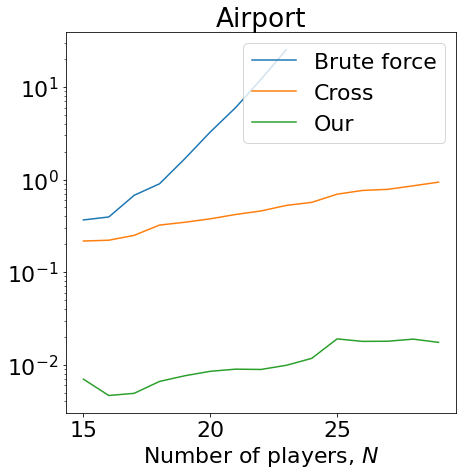

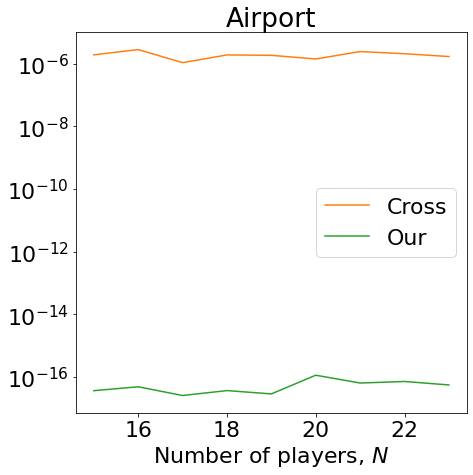

In [23]:
times_cur = {i: el for i, el in times_air.items() if i > 5}
plot_times([times_cur, times_cross_air, times_constr_air], 
           ['Brute force', r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Airport',
             fn='times_for_coop_games_air_times.pdf')


plot_errs(res_air, [res_cross_air, res_constr_air], 
           [r'Cross',  'Our'],
          x_label='Number of players, $N$',
             title='Airport',
             fn='times_for_coop_games_air_res.pdf')